In [1]:
from pca_dataflow_V2_variables import *

In [2]:
# Check if files exist
if os.path.exists(file):
    print(f"File exists: {file}")
else:
    print(f"File not found: {file}")

if os.path.exists(hdr_file):
    print(f"HDR File exists: {hdr_file}")
else:
    print(f"HDR File not found: {hdr_file}")

File exists: data\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img
HDR File exists: data\e_ang20180722t212222rfl\ang20180722t212222_rfl_v2r2_img.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(file)

c:\Users\patri\anaconda3\envs\my_thesis_env\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


In [4]:
#test_array = img_open.ReadAsArray()

In [5]:
#test_array.shape

In [6]:
# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (RasterXSize):\t"+str(ncols),"Rows (RasterYSize):\t"+str(nrows)]))

Bands:	425
Cols (RasterXSize):	689
Rows (RasterYSize):	17913


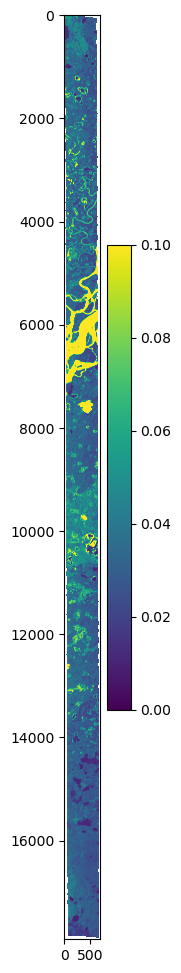

In [7]:
# read and display band 57 just to have a quick look at the image
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(img_red,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [8]:
'''
def save_array(output_path, array, num_bands, gdal_dataset, gdal_format = "GTiff", NoDataValue = -9999, data_type=gdal.GDT_Float32):
    """
    Saves a NumPy array as to a file.

    Args:
        output_path (str): The path to save the GeoTIF or ENVI file.
        array (numpy.ndarray): The NumPy array to save.
        num_bands (integer): Number of bands.
        gdal_dataset (gdal.Dataset): The GDAL dataset to use for geospatial information.
        gdal_format (str, optional): The GDAL format to use (default: "GTiff").
        NoDataValue (str or number): No data value. Usually -9999, 0 or np.nan.
        data_type (gdal.Datatype): GDT_Float32 or GDT_Byte 
    """
    driver = gdal.GetDriverByName(gdal_format)

    out_raster = driver.Create(
        output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        num_bands,
        data_type   
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())

    # Write the array band by band
    for i in range(num_bands):
        out_band = out_raster.GetRasterBand(i + 1)
        if num_bands == 1:
            out_band.WriteArray(array)
        else:
            #out_band.WriteArray(array[:, :, i])
            out_band.WriteArray(array[i])
        out_band.SetNoDataValue(NoDataValue)  # Or use 0 if appropriate
    out_raster.FlushCache()
'''

'\ndef save_array(output_path, array, num_bands, gdal_dataset, gdal_format = "GTiff", NoDataValue = -9999, data_type=gdal.GDT_Float32):\n    """\n    Saves a NumPy array as to a file.\n\n    Args:\n        output_path (str): The path to save the GeoTIF or ENVI file.\n        array (numpy.ndarray): The NumPy array to save.\n        num_bands (integer): Number of bands.\n        gdal_dataset (gdal.Dataset): The GDAL dataset to use for geospatial information.\n        gdal_format (str, optional): The GDAL format to use (default: "GTiff").\n        NoDataValue (str or number): No data value. Usually -9999, 0 or np.nan.\n        data_type (gdal.Datatype): GDT_Float32 or GDT_Byte \n    """\n    driver = gdal.GetDriverByName(gdal_format)\n\n    out_raster = driver.Create(\n        output_path,\n        gdal_dataset.RasterXSize,\n        gdal_dataset.RasterYSize,\n        num_bands,\n        data_type   \n    )\n    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())\n    out_raster.Set

In [9]:
# Define NoData value
nodata_value = -9999

# Extract the required bands (band 57, 34, and 20)
band_57 = img_open.GetRasterBand(57).ReadAsArray()
band_34 = img_open.GetRasterBand(34).ReadAsArray()
band_20 = img_open.GetRasterBand(20).ReadAsArray()

# Replace NoData values with NaN (or any other appropriate value)
# set fill values (-9999.) to 0 for each array
band_57[band_57 == nodata_value], band_34[band_34 == nodata_value], band_20[band_20 == nodata_value] = 0, 0, 0

# function scales reflectance values to 8bits
scale8bit = lambda a: ((a - a.min()) * (1/(a.max() - a.min()) * 255)).astype('uint8')

# get 8bit arrays for each band
band_57_8bit, band_34_8bit, band_20_8bit = scale8bit(band_57), scale8bit(band_34), scale8bit(band_20)

# set rescaled fill pixels back to 0 for each array
band_57_8bit[band_57 == 0], band_34_8bit[band_34 == 0], band_20_8bit[band_20 == 0] = 0, 0, 0

# c ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# make rgb stack
rgb_stack = np.zeros((nrows,ncols,3),'uint8')
rgb_stack[...,0], rgb_stack[...,1], rgb_stack[...,2] = band_57_8bit, band_34_8bit, band_20_8bit

# Rearrange to (RasterCount, RasterYSize, RasterXSize)
reordered_rgb_stack = np.transpose(rgb_stack, (2, 0, 1))

In [10]:
# Define output file path
RGB_file = os.path.join(input_dir, "output_rgb_image.tif")

# Save the RGB image as a GeoTIFF
save_array(RGB_file, reordered_rgb_stack,reordered_rgb_stack.shape[0], img_open,"GTiff",0,gdal.GDT_Byte)

print(f"RGB image saved as {RGB_file}")

RGB image saved as data\e_ang20180722t212222rfl\output_rgb_image.tif


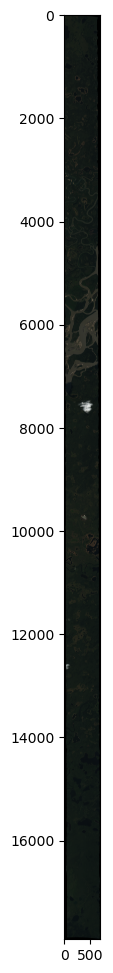

In [11]:
plt.rcParams["figure.figsize"] = [2,12]
plt.rcParams["figure.dpi"] = 100
plt.imshow(rgb_stack)
plt.show()

In [12]:
del band_57, band_34, band_20, band_57_8bit, band_34_8bit, band_20_8bit, rgb_stack
gc.collect()

7973

# Calculate SAVI

In [13]:
# Define band ranges for NIR, Green, and Red
nir_bands = range(86, 106)  # Bands 86 to 105 (1-based indexing in GDAL)
green_bands = range(26, 46)  # Bands 26 to 45
red_bands = range(56, 66)    # Bands 56 to 65

# Function to calculate the mean for a range of bands
def calculate_band_average(img, band_range):
    band_arrays = []
    for band_index in band_range:
        band_data = img.GetRasterBand(band_index).ReadAsArray()  # Read band
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace invalid values with NaN
        band_arrays.append(band_data)
    # Stack bands and calculate the mean along the 0th axis
    return np.nanmean(np.stack(band_arrays, axis=0), axis=0)

# Calculate averages for each range
nir_average = calculate_band_average(img_open, nir_bands)
green_average = calculate_band_average(img_open, green_bands)
red_average = calculate_band_average(img_open, red_bands)

C:\Users\patri\AppData\Local\Temp\ipykernel_14884\2333493103.py:14: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.stack(band_arrays, axis=0), axis=0)


In [14]:
# Define SAVI parameters
SAVI_L = 0.5  # Adjust this based on your requirements
SAVI_threshold = 0.2  # Example threshold for vegetation identification

# Calculate the SAVI
SAVI = ((nir_average - red_average) * (1 + SAVI_L)) / (nir_average + red_average + SAVI_L)

# Create a SAVI mask
savi_mask = np.where(SAVI > SAVI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
#savi_mask = np.where(savi_mask == 0, np.nan, 1)

# Save SAVI and savi_mask

# ENVI format
SAVI_file_envi = os.path.join(input_dir, "SAVI")
SAVI_mask_file_envi = os.path.join(input_dir, "SAVI_mask")
save_array(SAVI_file_envi, SAVI, 1, img_open,"ENVI")
save_array(SAVI_mask_file_envi, savi_mask, 1, img_open,"ENVI")

#Geotiff format
SAVI_file = os.path.join(input_dir, "SAVI.tif")
SAVI_mask_file = os.path.join(input_dir, "SAVI_mask.tif")
save_array(SAVI_file, SAVI, 1, img_open,"GTiff")
save_array(SAVI_mask_file, savi_mask, 1, img_open,"GTiff")

print(f'SAVI mask saved as GTiff {SAVI_mask_file}')
print(f'SAVI mask saved as ENVI {SAVI_mask_file_envi}')
print(f'SAVI saved as GTiff {SAVI_mask_file}')
print(f'SAVI saved as ENVI {SAVI_file_envi}')

SAVI mask saved as GTiff data\e_ang20180722t212222rfl\SAVI_mask.tif
SAVI mask saved as ENVI data\e_ang20180722t212222rfl\SAVI_mask
SAVI saved as GTiff data\e_ang20180722t212222rfl\SAVI_mask.tif
SAVI saved as ENVI data\e_ang20180722t212222rfl\SAVI


# Calculate NDWI

In [15]:
# Formula: NDWI = (Green – NIR)/(Green + NIR)

# Define NDWI parameters
# The NDWI values correspond to the following ranges:
# 0,2 – 1 – Water surface,
# 0.0 – 0,2 – Flooding, humidity,
# -0,3 – 0.0 – Moderate drought, non-aqueous surfaces,
# -1 – -0.3 – Drought, non-aqueous surfaces

NDWI_threshold = 0.2

# Calculate the SAVI
NDWI = (green_average - nir_average)/(green_average + nir_average)

# Create a SAVI mask
ndwi_mask = np.where(NDWI > NDWI_threshold, 1, np.nan)

# Set value 0 to NaN to exclude unwanted pixels
ndwi_mask = np.where(ndwi_mask == 0, np.nan, ndwi_mask)

# Save NDWI and ndwi_mask

# ENVI format
NDWI_file_envi = os.path.join(input_dir, "NDWI")
NDWI_mask_file_envi = os.path.join(input_dir, "NDWI_mask")
save_array(NDWI_file_envi, NDWI, 1, img_open,"ENVI")
save_array(NDWI_mask_file_envi, ndwi_mask, 1, img_open,"ENVI")

#Geotiff format
NDWI_file = os.path.join(input_dir, "NDWI.tif")
NDWI_mask_file = os.path.join(input_dir, "NDWI_mask.tif")
save_array(NDWI_file, NDWI, 1, img_open,"GTiff")
save_array(NDWI_mask_file, ndwi_mask, 1, img_open,"GTiff")

print(f'NDWI mask saved as GTiff {NDWI_mask_file}')
print(f'NDWI mask saved as ENVI {NDWI_mask_file_envi}')
print(f'NDWI saved as GTiff {NDWI_file}')
print(f'NDWI saved as ENVI {NDWI_file_envi}')

NDWI mask saved as GTiff data\e_ang20180722t212222rfl\NDWI_mask.tif
NDWI mask saved as ENVI data\e_ang20180722t212222rfl\NDWI_mask
NDWI saved as GTiff data\e_ang20180722t212222rfl\NDWI.tif
NDWI saved as ENVI data\e_ang20180722t212222rfl\NDWI


In [16]:
del nir_bands, green_bands, red_bands, nir_average, green_average, red_average
gc.collect()

0

# Perform PCA

In [17]:
# File path
pca_model_file = os.path.join(input_dir, "pca_model.pkl")
pca_result_file = os.path.join(input_dir, "pca_result.npz")

In [18]:
perform_pca = True

if(perform_pca):
    # Load the SAVI mask
    savi_mask_ds = gdal.Open(SAVI_mask_file)
    savi_mask = savi_mask_ds.GetRasterBand(1).ReadAsArray()
    savi_mask = np.where(savi_mask == 1, 1, np.nan)  # Keep only 1s, set others to NaN

    # Prepare hyperspectral image data
    bands = img_open.RasterCount  # Number of bands in the image
    rows, cols = savi_mask.shape

    # Initialize an empty list to store valid pixel data
    valid_pixels = []

    # Define the bands to include based on bblist
    bblist = np.ones((425,))
    bblist[0:14] = 0
    bblist[189:225] = 0
    bblist[281:336] = 0
    bblist[405:] = 0

    # Convert bblist to boolean mask for included bands
    included_bands = np.where(bblist == 1)[0] + 1  # GDAL bands are 1-based
    num_included_bands = len(included_bands)

    # Loop through only the included bands
    valid_pixels = []
    for band_index in included_bands:
        band_data = img_open.GetRasterBand(int(band_index)).ReadAsArray()
        band_data = np.where(band_data == -9999, np.nan, band_data)  # Replace no-data values with NaN
        # Apply mask
        masked_data = band_data * savi_mask  # Retain only pixels where mask == 1
        valid_pixels.append(masked_data)

    # Stack all bands into a single 3D array (bands, rows, cols)
    image_stack = np.stack(valid_pixels, axis=0)

    # Flatten the image stack (bands, rows*cols) and remove NaN
    flattened_pixels = image_stack.reshape(num_included_bands, -1).T  # Shape: (pixels, included_bands)
    filtered_pixels = flattened_pixels[~np.isnan(flattened_pixels).any(axis=1)]  # Exclude NaN

    # Standardize the data (scaling)
    scaler = StandardScaler()
    filtered_pixels_scaled = scaler.fit_transform(filtered_pixels)

    # Perform PCA
    #n_components = 30  # Maximum number of PCs to retain
    #pca = PCA(n_components=n_components)

    variance_to_retaine = 0.999
    pca = PCA(n_components=variance_to_retaine)

    pca_result = pca.fit_transform(filtered_pixels_scaled)  # Shape: (valid_pixels, n_components)

    # The number of components remaining
    num_components = pca.n_components_
    num_selected_pcs = num_components
    print(f'Number of components to retain {pca.n_components*100}% variance: {num_components}')

    # Save PCA model using pickle
    with open(pca_model_file, "wb") as f:
        pickle.dump(pca, f)

    # Save PCA-transformed data using NumPy
    np.savez(pca_result_file, pca_result=pca_result)

Number of components to retain 99.9% variance: 17


In [19]:
load_model = False

if(load_model):
    # Load PCA model
    with open(pca_model_file, "rb") as f:
        loaded_pca = pickle.load(f)

    # Load PCA-transformed data
    loaded_data = np.load(pca_result_file)
    pca_result = loaded_data["pca_result"]

In [20]:
#explained_variance_threshold = 0.999

# Select PCs that explain 99% variance
#num_selected_pcs = np.searchsorted(cumulative_variance, explained_variance_threshold) + 1  # Find index where cumulative variance >= 99%
#selected_pcs = pca_result[:, :num_selected_pcs]  # Retain only the selected PCs
all_pcs = pca_result[:, :]


In [ ]:
del pca_result
gc.collect()

In [21]:
# Create a vector of selected component numbers
selected_component_numbers = list(range(1, num_components + 1))

print(f"PCs selected: {selected_component_numbers}")

# File path
pc_number_file = os.path.join(input_dir, "Selected_Components.txt")

# Open the file in write mode
with open(pc_number_file, "w") as file:
    # Write each number on a new line
    for i in range(1, num_selected_pcs + 1):
        file.write(f"{i}\n")

print(f"Optimal number of clusters saved to {pc_number_file}.")

PCs selected: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
Optimal number of clusters saved to data\e_ang20180722t212222rfl\Selected_Components.txt.


In [22]:
# Reshape selected PCs back to spatial dimensions
#reshaped_selected_pcs = np.full((num_selected_pcs, rows, cols), np.nan)  # Initialize with NaN
reshaped_pcs = np.full((num_components, rows, cols), np.nan)  # Initialize with NaN
valid_indices = np.where(~np.isnan(flattened_pixels).any(axis=1))[0]

# reshape selected PCs
#for pc_index in range(num_selected_pcs):
#    reshaped_selected_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = selected_pcs[:, pc_index]

# reshape all PCs
for pc_index in range(num_components):
    reshaped_pcs[pc_index][np.unravel_index(valid_indices, (rows, cols))] = all_pcs[:, pc_index]

In [23]:
'''
# Save each PC as a separate band in a GeoTIFF
def save_multiband_tif(output_path, data, gdal_dataset):
    driver = gdal.GetDriverByName("GTiff")
    out_raster = driver.Create(output_path,
        gdal_dataset.RasterXSize,
        gdal_dataset.RasterYSize,
        data.shape[0],  # Number of bands
        gdal.GDT_Float32
    )
    out_raster.SetGeoTransform(gdal_dataset.GetGeoTransform())
    out_raster.SetProjection(gdal_dataset.GetProjection())
    
    for band_index in range(data.shape[0]):
        out_band = out_raster.GetRasterBand(band_index + 1)
        out_band.WriteArray(data[band_index])
        out_band.SetNoDataValue(np.nan)
    
    out_raster.FlushCache()
'''

# Save the selected PCs as a GeoTIFF
#PCA_selection_file = os.path.join(input_dir, "PCA_selected.tif")
#save_multiband_tif(PCA_selection_file, reshaped_selected_pcs, img_open)

PCA_file = os.path.join(input_dir, "PCA.tif")
save_array(PCA_file, reshaped_pcs, reshaped_pcs.shape[0], img_open,"GTiff")

#save_multiband_tif(PCA_file, reshaped_pcs, img_open)

print(f'PCA file saved as {PCA_file}')

PCA file saved as data\e_ang20180722t212222rfl\PCA.tif


In [24]:
# Save the selected PCs as a GeoTIFF
Rectified_PCA_file = os.path.join(input_dir, "PCA_rectified")
#Rectified_PCA_selection_file = os.path.join(input_dir, "PCA_selection_rectified")

# Construct the GDAL command
gdal_command_rectify = [
    "gdalwarp",
    "-of", "ENVI",                   # Output format
    "-co", "INTERLEAVE=BIL",         # Create ENVI format with BIL interleaving
    "-dstnodata", "-9999",           # Set nodata value
    PCA_file,
    Rectified_PCA_file
]

# Execute the command in Python
try:
    subprocess.run(gdal_command_rectify, check=True)
    print(f"Rectified image saved to {Rectified_PCA_file}")
except subprocess.CalledProcessError as e:
    print(f"An error occurred: {e}")

Rectified image saved to data\e_ang20180722t212222rfl\PCA_rectified


In [25]:
'''
# Define the total number of bands
#total_bands = nbands

# Define the ranges of bands to exclude
#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3
#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8
#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8

# Combine all the excluded ranges into one list
#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)

# Get the list of all band indices
all_bands = list(range(1, num_selected_pcs + 1))

# Exclude the specified bands
# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]

# Create the string in the desired format
rem_bands = " ".join([f"-b {band}" for band in all_bands])
# Split the string into a list
band_selection_args = rem_bands.split()
#band_selection_args = str(band_selection_args)[1:-1]

# Print the result
print(rem_bands)
print(band_selection_args)
'''

'\n# Define the total number of bands\n#total_bands = nbands\n\n# Define the ranges of bands to exclude\n#exclude_1 = range(1, 4)  # Excludes bands 1, 2, 3\n#exclude_2 = range(6, 9)  # Excludes bands 6, 7, 8\n#exclude_3 = range(11, 16)  # Excludes bands 6, 7, 8\n\n# Combine all the excluded ranges into one list\n#excluded_bands = set(exclude_1).union(exclude_2).union(exclude_3)\n\n# Get the list of all band indices\nall_bands = list(range(1, num_selected_pcs + 1))\n\n# Exclude the specified bands\n# remaining_bands = [str(band) for band in all_bands if band not in excluded_bands]\n\n# Create the string in the desired format\nrem_bands = " ".join([f"-b {band}" for band in all_bands])\n# Split the string into a list\nband_selection_args = rem_bands.split()\n#band_selection_args = str(band_selection_args)[1:-1]\n\n# Print the result\nprint(rem_bands)\nprint(band_selection_args)\n'

In [26]:
'''
def gdal_transform(band_sel, input_file, output_file, output_format):
    # Construct the GDAL command
    gdal_command_subbands = [
        "gdal_translate",
        *band_sel,       #Unpack with asteriks
        "-of", 
        output_format,                   # Output format
        input_file,
        output_file
    ]

    print(gdal_command_subbands)

    # Execute the command in Python
    try:
        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)
        print(f"Command succeeded:\n{result.stdout}")
    except subprocess.CalledProcessError as e:
        print(f"Command failed:\n{e.stderr}")
'''

'\ndef gdal_transform(band_sel, input_file, output_file, output_format):\n    # Construct the GDAL command\n    gdal_command_subbands = [\n        "gdal_translate",\n        *band_sel,       #Unpack with asteriks\n        "-of", \n        output_format,                   # Output format\n        input_file,\n        output_file\n    ]\n\n    print(gdal_command_subbands)\n\n    # Execute the command in Python\n    try:\n        result = subprocess.run(gdal_command_subbands, check=True, text=True, capture_output=True)\n        print(f"Command succeeded:\n{result.stdout}")\n    except subprocess.CalledProcessError as e:\n        print(f"Command failed:\n{e.stderr}")\n'

In [27]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")
'''

'\nPCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection")\ngdal_transform(band_selection_args,PCA_file,PCA_selection_file,"ENVI")\n'

In [28]:
'''
PCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")
gdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")
'''

'\nPCA_selection_file = os.path.join(input_dir, "PCA_rectified_selection.tif")\ngdal_transform(band_selection_args,PCA_file,PCA_selection_file,"GTiff")\n'

# Reset workspace

In [29]:
%reset -f

In [30]:
from pca_dataflow_V2_variables import *

# Perform WSS Elbow Method

In [31]:
PCA_selection_file = os.path.join(input_dir, "PCA.tif")

In [32]:
# open the hyperspectral image file with GDAL
img_open_pca_selection = gdal.Open(PCA_selection_file)

In [33]:
# read a few key properties of the image
bands = img_open_pca_selection.RasterCount
cols = img_open_pca_selection.RasterXSize
rows = img_open_pca_selection.RasterYSize

print("\n".join(["Bands:\t"+str(bands),"Cols (RasterXSize):\t"+str(cols),"Rows (RasterYSize):\t"+str(rows)]))

Bands:	17
Cols (RasterXSize):	689
Rows (RasterYSize):	17913


In [34]:
'''
# Initialize an empty array to hold the data
pca_data_selection = np.empty((nbands_sel, nrows_sel, ncols_sel), dtype=np.float32)
# Read each band into the array
for i in range(nbands_sel):
    band = img_open_pca_selection.GetRasterBand(i + 1)
    pca_data_selection[i] = band.ReadAsArray()
'''

'\n# Initialize an empty array to hold the data\npca_data_selection = np.empty((nbands_sel, nrows_sel, ncols_sel), dtype=np.float32)\n# Read each band into the array\nfor i in range(nbands_sel):\n    band = img_open_pca_selection.GetRasterBand(i + 1)\n    pca_data_selection[i] = band.ReadAsArray()\n'

In [35]:
pca_data_selection = img_open_pca_selection.ReadAsArray()
print(f'Dimensions {pca_data_selection.shape}')

Dimensions (17, 17913, 689)


In [36]:
pca_selection_data = img_open_pca_selection.ReadAsArray()
pca_data_selection_2d = pca_selection_data.reshape(bands, -1).T

# Remove pixels with NaN values
valid_pixels = pca_data_selection_2d[~np.isnan(pca_data_selection_2d).any(axis=1)]

In [37]:
valid_pixels_unique_count = np.unique(valid_pixels, axis=0)
print(f"Number of unique pixels: {valid_pixels_unique_count.shape[0]}")
print("Valid pixels shape:", valid_pixels.shape)

Number of unique pixels: 8366921
Valid pixels shape: (9520106, 17)


In [38]:
''' 
# Step 3: Apply the elbow method
# Range of cluster counts to try
k_range = range(1, 30)
wcss = []  # Within-cluster sum of squares

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(valid_pixels)
    wcss.append(kmeans.inertia_)
    print(f'Cluster {k} processed')

# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")
''' 

' \n# Step 3: Apply the elbow method\n# Range of cluster counts to try\nk_range = range(1, 30)\nwcss = []  # Within-cluster sum of squares\n\nfor k in k_range:\n    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)\n    kmeans.fit(valid_pixels)\n    wcss.append(kmeans.inertia_)\n    print(f\'Cluster {k} processed\')\n\n# Step 4: Plot the elbow curve\nplt.figure(figsize=(10, 6))\nplt.plot(k_range, wcss, marker=\'o\', linestyle=\'-\', color=\'b\')\nplt.title(\'Elbow Method for Optimal k\')\nplt.xlabel(\'Number of Clusters (k)\')\nplt.ylabel(\'Within-Cluster Sum of Squares (WCSS)\')\nplt.grid()\nplt.show()\n\n# Step 5: Determine optimal k (manual inspection or heuristic)\noptimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic\nprint(f"Optimal number of clusters: {optimal_k}")\n'

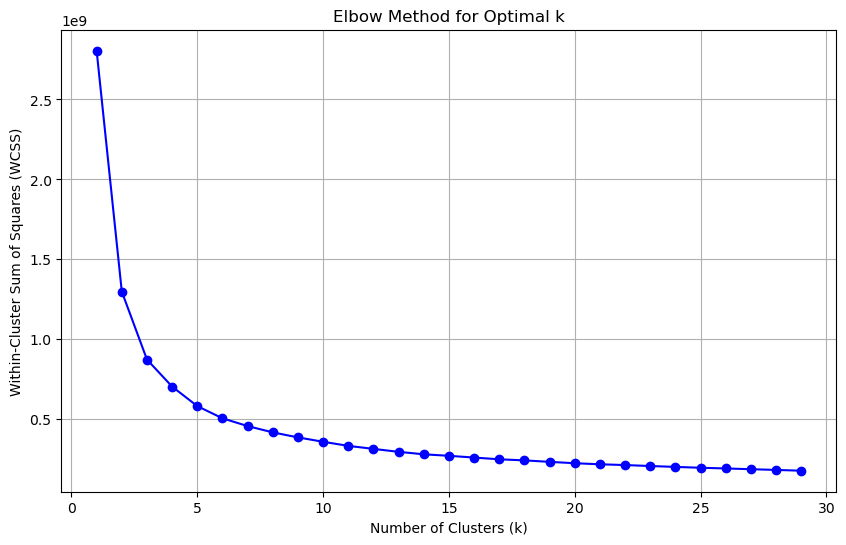

Optimal number of clusters: 18


In [39]:
# Define function to compute WCSS for a single value of k
def compute_wcss(k, data):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=1)
    kmeans.fit(data)
    print(f'Cluster {k} processed')
    return kmeans.inertia_

# Parallel computation of WCSS
k_range = range(1, 30)  # Define the range of cluster counts to try
#num_cores = -1  # Use all available cores (-1)

num_cores = os.cpu_count() - 2  # Reserve 2 cores for the system
if num_cores < 1:
    num_cores = 1  # Ensure at least one core is used

wcss = Parallel(n_jobs=num_cores)(
    delayed(compute_wcss)(k, valid_pixels) for k in k_range
)

#print("WCSS for all cluster values:", wcss)

# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid()
plt.show()

# Step 5: Determine optimal k (manual inspection or heuristic)
optimal_k = k_range[np.argmin(np.diff(wcss, 2)) + 1]  # Using the second derivative heuristic
print(f"Optimal number of clusters: {optimal_k}")


In [40]:
spectral_species_file = os.path.join(input_dir, "spectral_species.tif")

In [41]:
# Step 2: Perform k-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
cluster_labels = kmeans.fit_predict(valid_pixels)

# Step 3: Reshape clustered data back into spatial dimensions
cluster_image = np.full((rows, cols), -9999, dtype=int)  # Initialize with NaN
valid_indices = np.where(~np.isnan(pca_data_selection_2d).any(axis=1))[0]
cluster_image[np.unravel_index(valid_indices, (rows, cols))] = cluster_labels

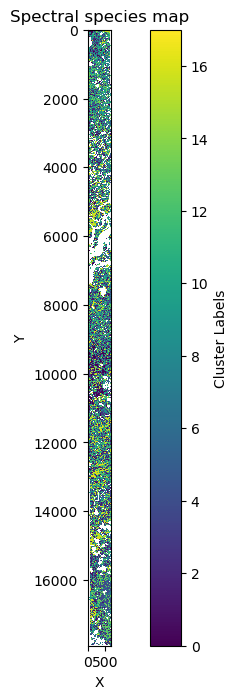

In [42]:
# Mask the no-data values (-9999)
masked_image = np.ma.masked_where(cluster_image == -9999, cluster_image)

# Plot the image with transparency for no-data values
plt.figure(figsize=(10, 8))
plt.imshow(masked_image, cmap='viridis', interpolation='none')  # interpolation='none' ensures no smoothing
plt.colorbar(label='Cluster Labels')
plt.title('Spectral species map')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [43]:
save_array(spectral_species_file, cluster_image, 1, img_open_pca_selection,"GTiff")
print(f'Spectral species file saved as {spectral_species_file}')

'''
# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    spectral_species_file, cols, rows, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None

print(f"K-means clustering result saved to {spectral_species_file}")
'''

Spectral species file saved as data\e_ang20180722t212222rfl\spectral_species.tif


'\n# Step 4: Save the clustered image as GeoTIFF\ndriver = gdal.GetDriverByName("GTiff")\nout_raster = driver.Create(\n    spectral_species_file, cols, rows, 1, gdal.GDT_Int32\n)\n\n# Copy georeferencing information from PCA file\nout_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())\nout_raster.SetProjection(img_open_pca_selection.GetProjection())\n\n# Write cluster labels\nout_band = out_raster.GetRasterBand(1)\nout_band.WriteArray(cluster_image)\nout_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels\nout_band.FlushCache()\n\n# Close datasets\nout_raster = None\nds = None\n\nprint(f"K-means clustering result saved to {spectral_species_file}")\n'

In [44]:
'''
# Step 4: Save the clustered image as GeoTIFF
driver = gdal.GetDriverByName("GTiff")
out_raster = driver.Create(
    output_cluster_file, ncols_sel, nrows_sel, 1, gdal.GDT_Int32
)

# Copy georeferencing information from PCA file
out_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())
out_raster.SetProjection(img_open_pca_selection.GetProjection())

# Write cluster labels
out_band = out_raster.GetRasterBand(1)
out_band.WriteArray(cluster_image)
out_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels
out_band.FlushCache()

# Close datasets
out_raster = None
ds = None


print(f"K-means clustering result saved to {output_cluster_file}")
'''

'\n# Step 4: Save the clustered image as GeoTIFF\ndriver = gdal.GetDriverByName("GTiff")\nout_raster = driver.Create(\n    output_cluster_file, ncols_sel, nrows_sel, 1, gdal.GDT_Int32\n)\n\n# Copy georeferencing information from PCA file\nout_raster.SetGeoTransform(img_open_pca_selection.GetGeoTransform())\nout_raster.SetProjection(img_open_pca_selection.GetProjection())\n\n# Write cluster labels\nout_band = out_raster.GetRasterBand(1)\nout_band.WriteArray(cluster_image)\nout_band.SetNoDataValue(-9999)  # Set NoData value for invalid pixels\nout_band.FlushCache()\n\n# Close datasets\nout_raster = None\nds = None\n\n\nprint(f"K-means clustering result saved to {output_cluster_file}")\n'

In [45]:
'''
import skbio.diversity.alpha as alpha
import numpy as np

# Assuming 'counts' is an array of cluster frequencies
shannon = alpha.shannon(counts)
simpson = alpha.simpson(counts)
'''

"\nimport skbio.diversity.alpha as alpha\nimport numpy as np\n\n# Assuming 'counts' is an array of cluster frequencies\nshannon = alpha.shannon(counts)\nsimpson = alpha.simpson(counts)\n"

In [46]:
Stop

NameError: name 'Stop' is not defined

In [44]:
%reset -f

In [45]:
from pca_dataflow_V2_variables import *

In [46]:
output_cluster_file = os.path.join(input_dir, "spectral_species.tif")

In [47]:
# open the hyperspectral image file with GDAL
spectral_species_img = gdal.Open(output_cluster_file)

In [ ]:
spectral_species_img_array = spectral_species_img.ReadAsArray()
print(spectral_species_img_array.shape)

In [ ]:
# Mask no-data values (-9999) by excluding them
valid_pixels = spectral_species_img_array[spectral_species_img_array != -9999]

print("Valid pixels:", valid_pixels)

In [ ]:
# Calculate frequencies for valid clusters
unique, counts = np.unique(valid_pixels, return_counts=True)

# Convert to float for diversity calculations
counts = counts.astype(float)

print("Cluster frequencies:", counts)

In [ ]:


# Shannon diversity
shannon_index = alpha.shannon(counts)

# Simpson diversity
simpson_index = alpha.simpson(counts)

print(f"Shannon Index: {shannon_index}")
print(f"Simpson Index: {simpson_index}")

In [ ]:
stop

In [52]:
# Define no-data value
no_data_value = -9999

# Step 1: Define a function to calculate Shannon diversity
def calculate_shannon(local_window):
    # Remove no-data values
    valid_values = local_window[local_window != no_data_value]
    if len(valid_values) == 0:  # If all values are no-data, return NaN
        return np.nan

    # Calculate frequencies of unique values
    _, counts = np.unique(valid_values, return_counts=True)
    
    # Compute Shannon diversity
    return shannon(counts.astype(float))

# Step 2: Apply the function to a sliding window
window_size = 3  # Define the neighborhood size (e.g., 3x3)
diversity_map = generic_filter(
    spectral_species_img_array, 
    calculate_shannon, 
    size=window_size, 
    mode='constant', 
    cval=no_data_value
)

# Replace NaN values with the no-data value
diversity_map_cleaned = np.where(np.isnan(diversity_map), no_data_value, diversity_map)

# Step 3: Save the result as a GeoTIFF
def save_geotiff(output_file, array, geo_transform, projection, no_data_value):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = array.shape
    
    # Create the GeoTIFF file
    dataset = driver.Create(output_file, cols, rows, 1, gdal.GDT_Float32)
    dataset.SetGeoTransform(geo_transform)  # Set the affine transformation
    dataset.SetProjection(projection)  # Set the projection

    # Write the array to the raster band
    band = dataset.GetRasterBand(1)
    band.WriteArray(array)
    band.SetNoDataValue(no_data_value)  # Set no-data value

    # Clean up
    band.FlushCache()
    dataset.FlushCache()
    dataset = None  # Close the file

In [ ]:
# Save the diversity map
shannon_diversity_file = os.path.join(vb.input_dir, "shannon_diversity.tif")
save_geotiff(shannon_diversity_file, diversity_map_cleaned, spectral_species_img.GetGeoTransform(), spectral_species_img.GetProjection(), no_data_value)

print(f"Diversity map saved to {shannon_diversity_file}")

In [104]:
import rasterio
import numpy as np
from skbio.diversity.alpha import shannon
from collections import Counter

def shannon_diversity_window(image_path, window_size, output_path, no_data_value=-9999):
    """
    Calculates Shannon diversity index for a clustered image using a moving window, 
    handling no-data values.

    Args:
        image_path (str): Path to the input image (GeoTIFF).
        window_size (int): Size of the moving window (e.g., 3 for a 3x3 window).
        output_path (str): Path to save the output diversity image (GeoTIFF).
        no_data_value (int, optional): Value representing no data in the image. 
                                        Defaults to -9999.
    """
    with rasterio.open(image_path) as src:
        image_data = src.read(1)
        profile = src.profile

        diversity_image = np.empty(image_data.shape, dtype=float)

        for i in range(0, image_data.shape[0] - window_size + 1, window_size):
            for j in range(0, image_data.shape[1] - window_size + 1, window_size):
                window = image_data[i:i+window_size, j:j+window_size]

                # Mask out no-data values in the window
                valid_pixels = window[window != no_data_value] 

                if valid_pixels.size > 0:  # Check if there are valid pixels
                    counts = np.array(list(Counter(valid_pixels).values()))
                    diversity_index = shannon(counts)
                else:
                    diversity_index = no_data_value  # Assign no_data_value if no valid pixels

                center_i = i + window_size // 2
                center_j = j + window_size // 2
                diversity_image[center_i, center_j] = diversity_index

        # Update profile for the output image
        profile.update(dtype=rasterio.float32, count=1, nodata=no_data_value)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(diversity_image, 1)

# Example usage
input_image = os.path.join(vb.input_dir, "spectral_species.tif") 
window_size = 20  # Example window size
output_image = os.path.join(vb.input_dir, "shannon_diversity_V2.tif")
shannon_diversity_window(input_image, window_size, output_image)